In [1]:
!git clone https://github.com/rguitar96/self-driving-udemy

Cloning into 'self-driving-udemy'...
remote: Enumerating objects: 16197, done.
remote: Counting objects: 100% (16197/16197), done.
remote: Compressing objects: 100% (16182/16182), done.
remote: Total 16197 (delta 22), reused 16177 (delta 9), pack-reused 0
Receiving objects: 100% (16197/16197), 243.61 MiB | 11.36 MiB/s, done.
Resolving deltas: 100% (22/22), done.
Checking out files: 100% (16398/16398), done.


In [2]:
!ls self-driving-udemy/10-behavioural-cloning/simulator-data/

driving_log.csv  IMG


In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Convolution2D, MaxPooling2D, Dropout, Flatten, Dense
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa
import cv2
import pandas as pd
import random

Using TensorFlow backend.


In [4]:
datadir = 'self-driving-udemy/10-behavioural-cloning/simulator-data/'
columns = ['center','left','right','steering','throttle','reserve','speed']
data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'),names=columns)
pd.set_option('display.max_colwidth',-1)
data.head()

center  ...     speed
0  D:\Proyectos\self-driving-udemy\simulator\data\IMG\center_2019_08_23_16_56_44_542.jpg  ...  0.000078
1  D:\Proyectos\self-driving-udemy\simulator\data\IMG\center_2019_08_23_16_56_44_686.jpg  ...  0.000079
2  D:\Proyectos\self-driving-udemy\simulator\data\IMG\center_2019_08_23_16_56_44_787.jpg  ...  0.000078
3  D:\Proyectos\self-driving-udemy\simulator\data\IMG\center_2019_08_23_16_56_44_887.jpg  ...  0.000079
4  D:\Proyectos\self-driving-udemy\simulator\data\IMG\center_2019_08_23_16_56_44_990.jpg  ...  0.000079

[5 rows x 7 columns]

In [0]:
def path_leaf(path):
  return path.split('\\')[-1]

In [6]:
data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)
data.head()

center  ...     speed
0  center_2019_08_23_16_56_44_542.jpg  ...  0.000078
1  center_2019_08_23_16_56_44_686.jpg  ...  0.000079
2  center_2019_08_23_16_56_44_787.jpg  ...  0.000078
3  center_2019_08_23_16_56_44_887.jpg  ...  0.000079
4  center_2019_08_23_16_56_44_990.jpg  ...  0.000079

[5 rows x 7 columns]

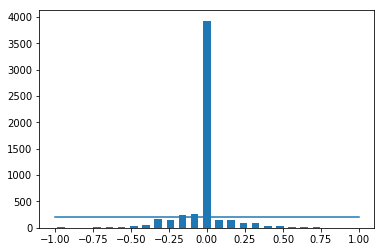

In [7]:
num_bins = 25
samples_per_bin = 200
hist,bins = np.histogram(data['steering'],num_bins)
center = (bins[:-1]+bins[1:]) * 0.5
plt.bar(center,hist,width=0.05)
plt.plot((np.min(data['steering']),np.max(data['steering'])),(samples_per_bin,samples_per_bin))
# we can see data is not quite balanced, as there is more data for one direction
# of the circuit than the other

total data: 5456
removed: 3828
remaining: 1628


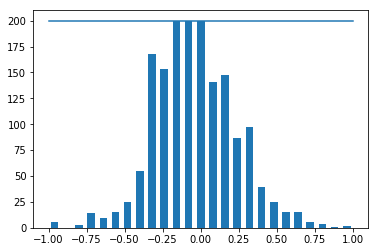

In [8]:
print('total data:', len(data))
remove_list = []
for j in range(num_bins):
  list_ = []
  for i in range(len(data['steering'])):
    if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]:
      list_.append(i)
  list_ = shuffle(list_)
  list_ = list_[samples_per_bin:]
  remove_list.extend(list_)
print('removed:', len(remove_list))
data.drop(data.index[remove_list], inplace=True)
print('remaining:', len(data))
 
hist, _ = np.histogram(data['steering'], (num_bins))
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

In [0]:
def load_img_steering(datadir, df):
  image_path = []
  steering = []
  for i in range(len(df)):
    indexed_data = df.iloc[i]
    center,left,right = indexed_data[0],indexed_data[1],indexed_data[2]
    image_path.append(os.path.join(datadir,center.strip()))
    steering.append(float(indexed_data[3]))
  image_path = np.asarray(image_path)
  steering = np.asarray(steering)
  return image_path,steering

In [0]:
image_paths,steerings = load_img_steering(datadir+'/IMG',data)

In [0]:
X_train,X_val,y_train,y_val = train_test_split(image_paths,steerings,test_size=0.2,random_state=1)

In [12]:
print(len(X_train))
print(len(X_val))

1302
326


Text(0.5, 1.0, 'Validation set')

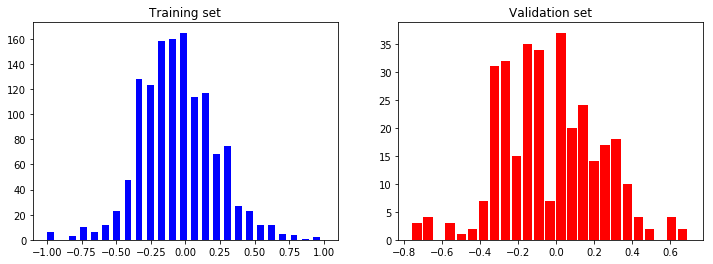

In [13]:
fig,axes = plt.subplots(1,2,figsize=(12,4))
axes[0].hist(y_train,bins=num_bins,width=0.05,color='blue')
axes[0].set_title('Training set')
axes[1].hist(y_val,bins=num_bins,width=0.05,color='red')
axes[1].set_title('Validation set')

In [0]:
def zoom(image):
  zoom = iaa.Affine(scale=(1,1.3))
  image = zoom.augment_image(image)
  return image

Text(0.5, 1.0, 'Zoomed Image')

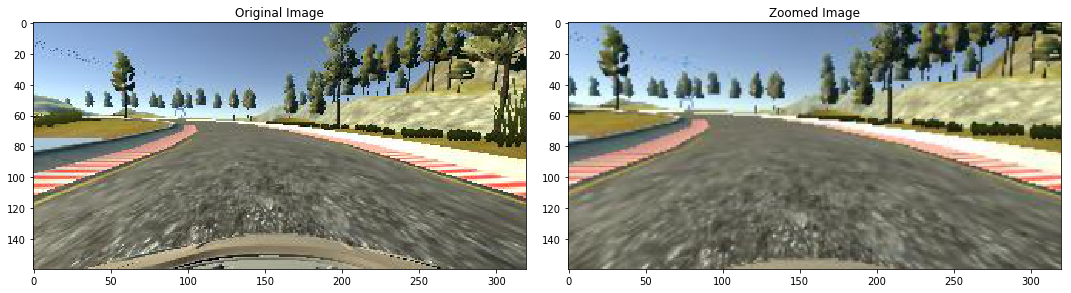

In [15]:
image = image_paths[random.randint(0,1000)]
original_image = mpimg.imread(image)
zoomed_image = zoom(original_image)

fig, axs = plt.subplots(1,2,figsize=(15,10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
axs[1].imshow(zoomed_image)
axs[1].set_title('Zoomed Image')

In [0]:
def pan(image):
  pan = iaa.Affine(translate_percent={ 'x': (-0.1,0.1), 'y': (-0.1,0.1) })
  image = pan.augment_image(image)
  return image

Text(0.5, 1.0, 'Panned Image')

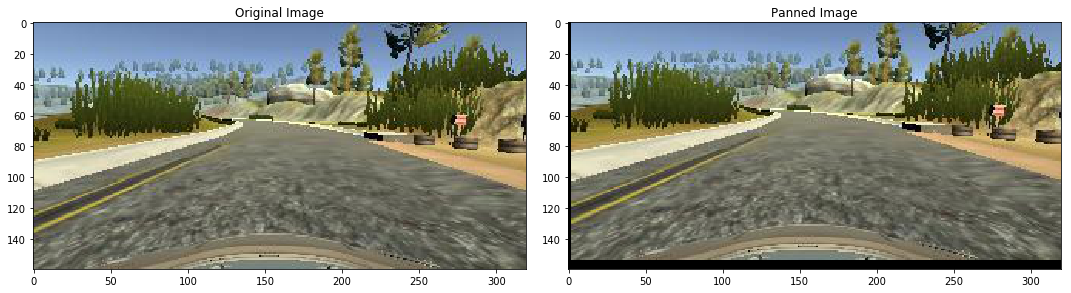

In [17]:
image = image_paths[random.randint(0,1000)]
original_image = mpimg.imread(image)
panned_image = pan(original_image)

fig, axs = plt.subplots(1,2,figsize=(15,10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
axs[1].imshow(panned_image)
axs[1].set_title('Panned Image')

In [0]:
def img_random_brightness(image):
  brightness = iaa.Multiply((0.2,1.2))
  image = brightness.augment_image(image)
  return image

Text(0.5, 1.0, 'Brightness Altered Image')

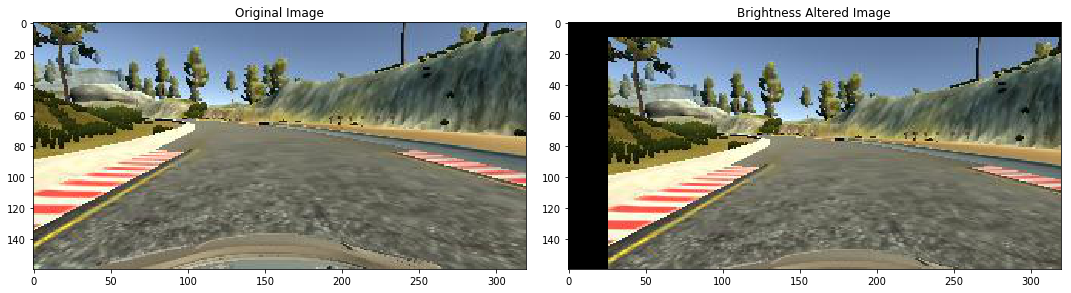

In [19]:
image = image_paths[random.randint(0,1000)]
original_image = mpimg.imread(image)
brightness_image = pan(original_image)

fig, axs = plt.subplots(1,2,figsize=(15,10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
axs[1].imshow(brightness_image)
axs[1].set_title('Brightness Altered Image')

In [0]:
def flip(image, steering_angle):
  image = cv2.flip(image, 1)
  steering_angle = -steering_angle
  return image, steering_angle

Text(0.5, 1.0, 'Flipped Image, Steering Angle: -0.18646379999999999')

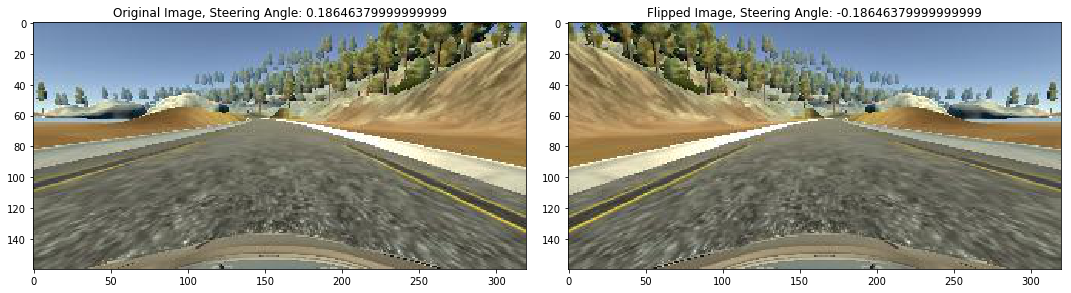

In [21]:
random_index = random.randint(0,1000)
image = image_paths[random_index]
steering_angle = steerings[random_index]
original_image = mpimg.imread(image)
flipped_image, flipped_steering_image = flip(original_image, steering_angle)

fig, axs = plt.subplots(1,2,figsize=(15,10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original Image, Steering Angle: ' + str(steering_angle))
axs[1].imshow(flipped_image)
axs[1].set_title('Flipped Image, Steering Angle: ' + str(flipped_steering_image))

In [0]:
def random_augment(image, steering_angle):
  image = mpimg.imread(image)
  if np.random.rand() > 0.5:
    image = pan(image)
  if np.random.rand() > 0.5:
    image = zoom(image)
  if np.random.rand() > 0.5:
    image = img_random_brightness(image)
  if np.random.rand() > 0.5:
    image, steering_angle = flip(image, steering_angle)
  return image, steering_angle

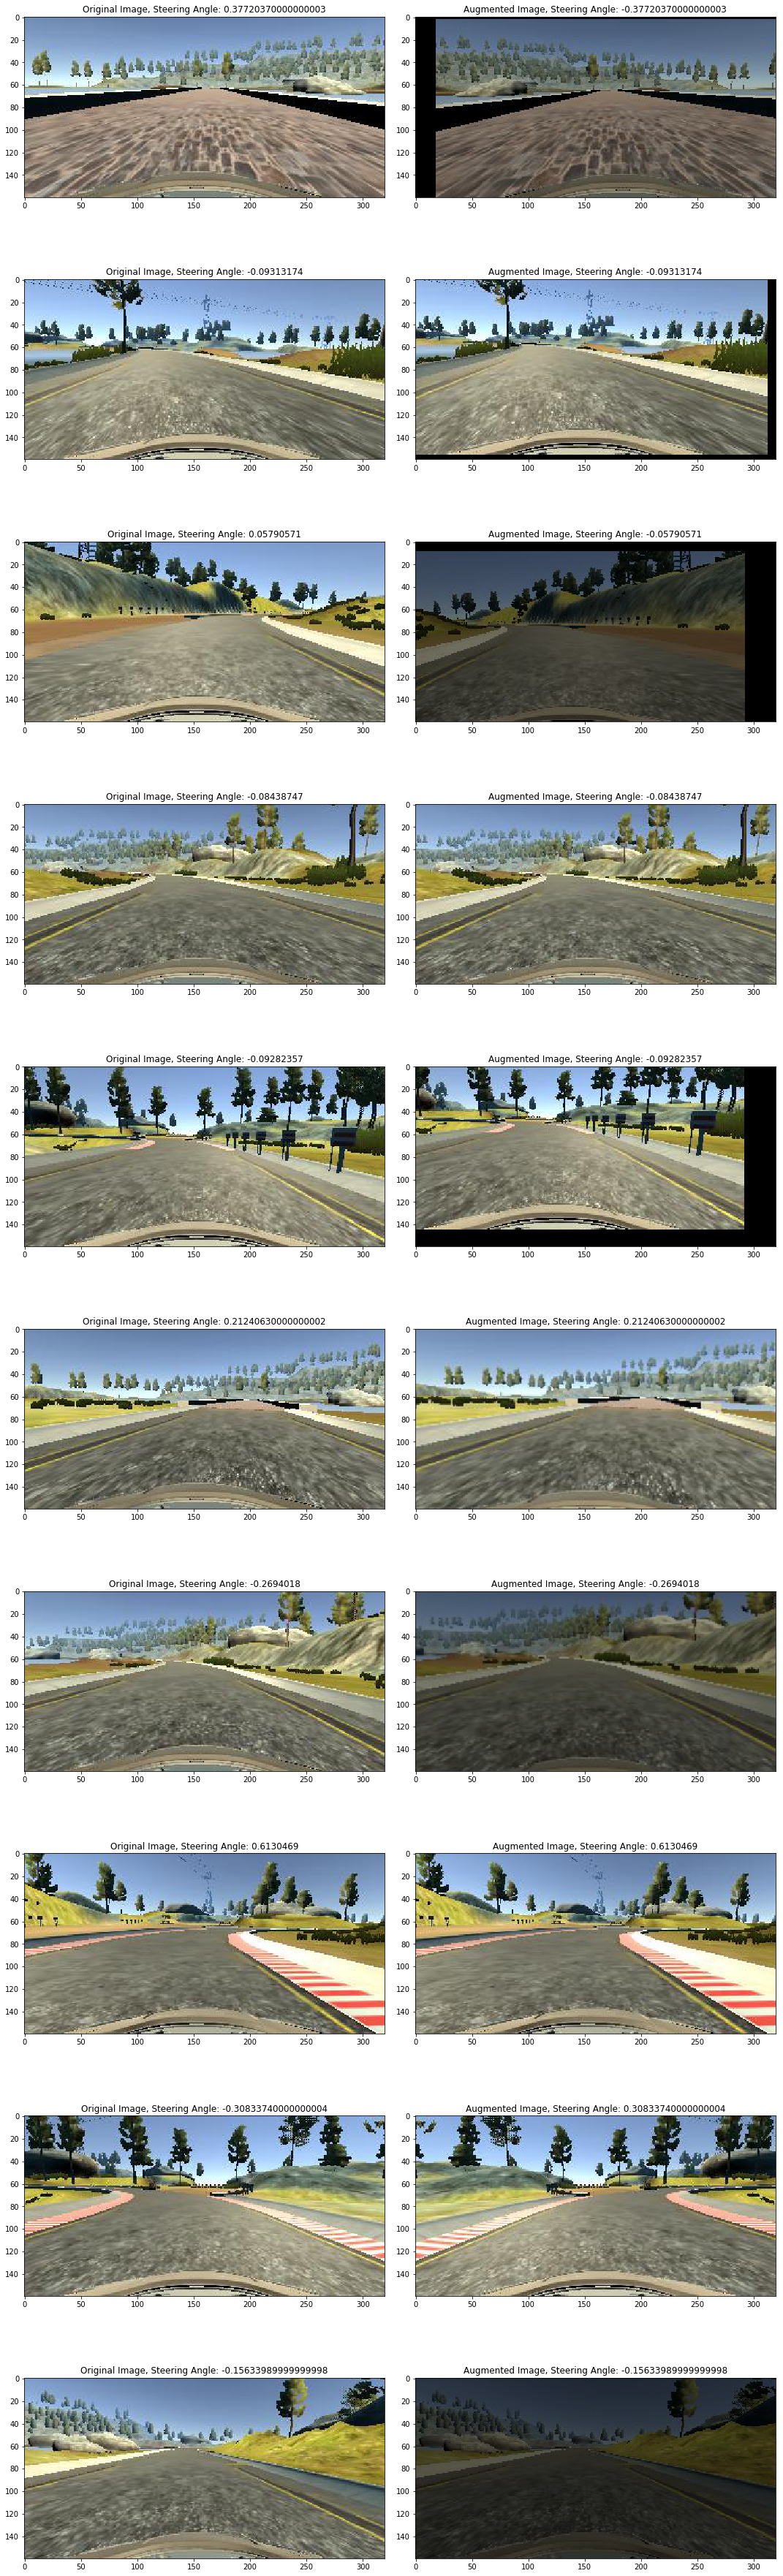

In [23]:
ncol = 2
nrow = 10
fig, axs = plt.subplots(nrow, ncol, figsize=(15,50))
fig.tight_layout()

for i in range(10):
  randnum = random.randint(0,len(image_paths)-1)
  random_image = image_paths[randnum]
  random_steering = steerings[randnum]
  
  original_image = mpimg.imread(random_image)
  augmented_image, steering = random_augment(random_image, random_steering)
  
  axs[i][0].imshow(original_image)
  axs[i][0].set_title('Original Image, Steering Angle: ' + str(random_steering))
  axs[i][1].imshow(augmented_image)
  axs[i][1].set_title('Augmented Image, Steering Angle: ' + str(steering))

In [0]:
def img_preprocess(img):
  img = img[int(0.38*img.shape[0]):int(0.85*img.shape[0]),:,:]
  # as we are going to use an nvidia model, we use YUV as recommended by their developers
  img = cv2.cvtColor(img,cv2.COLOR_RGB2YUV)
  img = cv2.GaussianBlur(img,(3,3),0)
  img = cv2.resize(img,tuple(reversed(tuple(int(0.75*x) for x in img.shape[:2]))))
  img = img/255
  return img

Text(0.5, 1.0, 'Preprocessed Image')

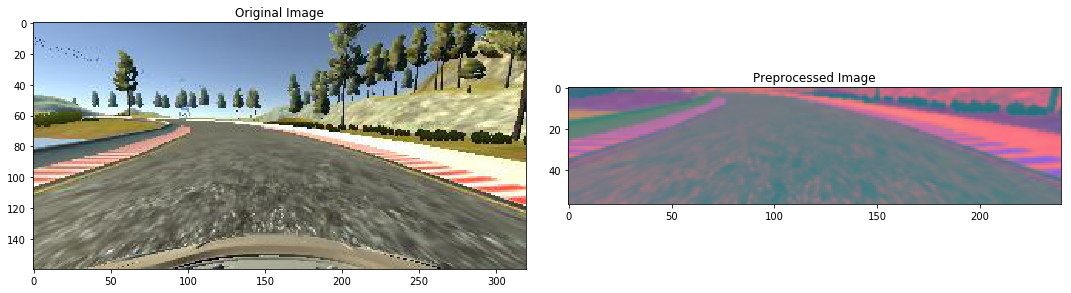

In [25]:
image = image_paths[100]
original_img = mpimg.imread(image)
preprocessed_img = img_preprocess(original_img)

fig,axes = plt.subplots(1,2,figsize=(15,10))
fig.tight_layout()
axes[0].imshow(original_img)
axes[0].set_title('Original Image')
axes[1].imshow(preprocessed_img)
axes[1].set_title('Preprocessed Image')

In [0]:
def batch_generator(image_paths, steering_ang, batch_size, istraining):
  while True:
    batch_img = []
    batch_steering = []
    
    for i in range(batch_size):
      random_index = random.randint(0, len(image_paths)-1)
      
      if istraining:
        img, steering = random_augment(image_paths[random_index], steering_ang[random_index])
      else:
        img = mpimg.imread(image_paths[random_index])
        steering = steering_ang[random_index]
      
      img = img_preprocess(img)
      batch_img.append(img)
      batch_steering.append(steering)
    yield (np.asarray(batch_img), np.asarray(batch_steering))

Text(0.5, 1.0, 'Validation Image')

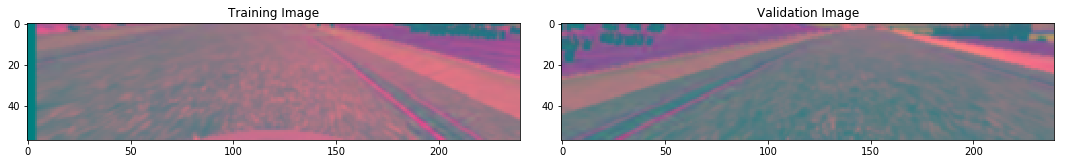

In [27]:
x_train_gen, y_train_gen = next(batch_generator(X_train, y_train, 1, True))
x_val_gen, y_val_gen = next(batch_generator(X_val, y_val, 1, False))

fig,axes = plt.subplots(1,2,figsize=(15,10))
fig.tight_layout()
axes[0].imshow(x_train_gen[0])
axes[0].set_title('Training Image')
axes[1].imshow(x_val_gen[0])
axes[1].set_title('Validation Image')

In [0]:
def nvidia_model():
  model = Sequential()
  model.add(Convolution2D(24,(5,5),subsample=(2,2),input_shape=(57,240,3),activation='elu'))
  model.add(Convolution2D(36,(5,5),subsample=(2,2),activation='elu'))
  model.add(Convolution2D(48,(5,5),subsample=(2,2),activation='elu'))
  model.add(Convolution2D(64,(3,3),activation='elu'))
  model.add(Convolution2D(64,(3,3),activation='elu',padding='same'))
  model.add(Flatten())
  model.add(Dense(100,activation='elu'))
  model.add(Dense(50,activation='elu'))
  model.add(Dense(10,activation='elu'))
  model.add(Dense(1))
  
  model.compile(loss='mse',optimizer=Adam(lr=0.0001))
  
  return model

In [37]:
model = nvidia_model()
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 27, 118, 24)       1824      
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 12, 57, 36)        21636     
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 4, 27, 48)         43248     
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 2, 25, 64)         27712     
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 2, 25, 64)         36928     
_________________________________________________________________
flatten_3 (Flatten)          (None, 3200)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 100)              

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (5, 5), input_shape=(57, 240, ..., activation="elu", strides=(2, 2))`
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(36, (5, 5), activation="elu", strides=(2, 2))`
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (5, 5), activation="elu", strides=(2, 2))`
  """


In [38]:
history = model.fit_generator(batch_generator(X_train, y_train, 100, True),
                               steps_per_epoch=300, 
                               epochs=10,
                               validation_data=batch_generator(X_val, y_val, 100, False),
                               validation_steps=200, 
                               verbose=1, 
                               shuffle=1)

Epoch 1/10
300/300 [==============================] - 154s 512ms/step - loss: 0.0663 - val_loss: 0.0460
Epoch 2/10
300/300 [==============================] - 150s 499ms/step - loss: 0.0538 - val_loss: 0.0443
Epoch 3/10
300/300 [==============================] - 150s 499ms/step - loss: 0.0502 - val_loss: 0.0437
Epoch 4/10
300/300 [==============================] - 150s 501ms/step - loss: 0.0469 - val_loss: 0.0399
Epoch 5/10
300/300 [==============================] - 150s 499ms/step - loss: 0.0448 - val_loss: 0.0395
Epoch 6/10
300/300 [==============================] - 150s 498ms/step - loss: 0.0434 - val_loss: 0.0403
Epoch 7/10
300/300 [==============================] - 150s 500ms/step - loss: 0.0409 - val_loss: 0.0358
Epoch 8/10
300/300 [==============================] - 150s 499ms/step - loss: 0.0401 - val_loss: 0.0387
Epoch 9/10
300/300 [==============================] - 149s 498ms/step - loss: 0.0386 - val_loss: 0.0374
Epoch 10/10
300/300 [==============================] - 150s 501m

Text(0.5, 0, 'Epoch')

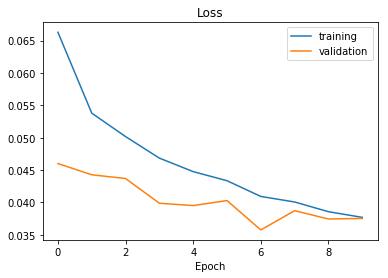

In [39]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training','validation'])
plt.title('Loss')
plt.xlabel('Epoch')

In [0]:
model.save('model.h5')

In [0]:
from google.colab import files
files.download('model.h5')